# Prueba de concepto 
## Emplazamiento local y post valoración global para ajustamiento con random forest

In [5]:
import sys
print(sys.version) #Python version 

3.9.7 (default, Nov  4 2021, 13:09:39) 
[Clang 12.0.5 (clang-1205.0.22.11)]


In [6]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
import multiprocessing
import warnings

warnings.filterwarnings('once')

## Modelling
### Topology

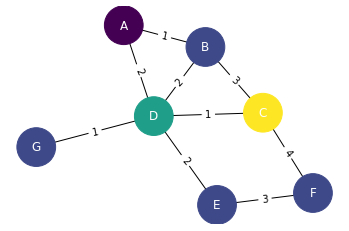

In [7]:
import networkx as nx
G = nx.Graph()

G.add_edges_from([('A', 'B'),('C','D'),('G','D')], latency=1)
G.add_edges_from([('D','A'),('D','E'),('B','D'),('D','E')], latency=2)
G.add_edges_from([('B','C'),('E','F')], latency=3)
G.add_edges_from([('C','F')], latency=4)

cost_map= {'A': 1.0,'D': 6.0,'C': 10.0}
costs = [cost_map.get(node, 3.0) for node in G.nodes()]
edge_labels= dict([((u,v,),d['latency']) for u,v,d in G.edges(data=True)])

node_labels = {node:node for node in G.nodes()}

pos=nx.spring_layout(G)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx_labels(G, pos, labels=node_labels,font_color="white") 
nx.draw(G,pos, node_color = costs, node_size=1500)

plt.show()

In [8]:
G.degree()

DegreeView({'A': 2, 'B': 3, 'C': 3, 'D': 5, 'G': 1, 'E': 2, 'F': 2})

In [30]:
max_latency = 7

In [9]:
nx.betweenness_centrality(G)

{'A': 0.0,
 'B': 0.05555555555555555,
 'C': 0.17777777777777776,
 'D': 0.5777777777777777,
 'G': 0.0,
 'E': 0.08888888888888888,
 'F': 0.03333333333333333}

### Users
Asignación estática de usuarios a nodos. Solo un usuario a esos nodos:

In [10]:
wl_users = {'C': 1,'G': 1,'E': 1}
users_at_node = [wl_users.get(node, 0) for node in G.nodes()]

### Services
Asignación de servicios a nodos. Esto cambiará... por ahora es una prueba

In [11]:
alloc_services = {"A":1}
alloc_services_at_node = [alloc_services.get(node, 0) for node in G.nodes()]
print(alloc_services_at_node)

[1, 0, 0, 0, 0, 0, 0]


In [12]:
#Test A: Routing services
# Calculamos la ruta de los servicios - usuarios
available_services = dict([k,alloc_services_at_node[ix]] for ix,k in enumerate(G.nodes()) if alloc_services_at_node[ix]>0 )
print(available_services)
print(wl_users)
routing_service = {} #key: user , value: (service,latency)
for (node,value) in wl_users.items():
    more_close = 0
    node_close = None
    for a_service in available_services:
        path_length = nx.shortest_path_length(G,node,a_service,weight="latency")
        if node_close == None:
            more_close = path_length
            node_close = a_service
        if path_length<more_close:
            more_close = path_length
            node_close = a_service
    
    routing_service[node]=(node_close,more_close)
    
print(routing_service)    #key: user , value: (service,latency)


{'A': 1}
{'C': 1, 'G': 1, 'E': 1}
{'C': ('A', 3), 'G': ('A', 3), 'E': ('A', 4)}


In [13]:
#Generamos una funcion de lo anterior
arrayofservices = [1, 1, 1, 1, 0, 1, 0]
def get_routings(arrayofservices):
    available_services = dict([k,arrayofservices[ix]] for ix,k in enumerate(G.nodes()) if arrayofservices[ix]>0 )
    if len(available_services)==0: return dict()
    routing_service = {} #key: user , value: (service,latency)
    for (node,value) in wl_users.items():
        more_close = 0
        node_close = None
        for a_service in available_services:
            path_length = nx.shortest_path_length(G,node,a_service,weight="latency")
            if node_close == None:
                more_close = path_length
                node_close = a_service
            if path_length<more_close:
                more_close = path_length
                node_close = a_service
        routing_service[node]=(node_close,more_close)
    return routing_service

print(get_routings(arrayofservices)) 

{'C': ('C', 0), 'G': ('D', 1), 'E': ('E', 0)}


## Global evaluation function
Como evaluaremos el modelo a nivel global. Para esta prueba algo muy simple:
- Goal: Latency == 0. All services with latency 0.
- Goal: One user with one service

In [33]:
#Average latency
avg_latency = np.array([v[1] for k,v in routing_service.items()])
avg_latency = (np.abs((avg_latency-max_latency)/max_latency)).mean()
print(avg_latency)

0.5238095238095238


In [35]:
#Total services
services = [v[0] for k,v in routing_service.items()]
total_services = len(np.unique(services))
print(total_services)
print(len(wl_users))
total_services/len(wl_users)

1
3


0.3333333333333333

In [37]:
#Evaluation value
def assignment_cardinality_eval(total_services,users):
    return total_services/users

def global_eval(avg_latency,total_services,wl_users):
    return avg_latency+assignment_cardinality_eval(total_services,len(wl_users))/2.0

geval = global_eval(avg_latency,total_services,wl_users)
print(geval)

0.6904761904761905


In [39]:
# ALL in one function
print(routing_service)
def compute_eval(routing_service):
    avg_latency = np.array([v[1] for k,v in routing_service.items()])
    avg_latency = (np.abs((avg_latency-max_latency)/max_latency)).mean()
    
    services = [v[0] for k,v in routing_service.items()]
    total_services = len(np.unique(services))
        
    assigment_eval = total_services/len(wl_users)
    return (avg_latency+assigment_eval)/2.

print(compute_eval(routing_service))

{'C': ('A', 3), 'G': ('A', 3), 'E': ('A', 4)}
0.4285714285714286


## Design considerations of the RF input :
- Dimensionality problem - samples representation: ¿qué granularidad es introducida en el modelo de datos? > Columnas
- Evaluation goals



In [40]:
actions_labels = ["None","Migrate","Replicate","Undeploy"]
actions = np.arange(len(actions_labels)) #dummies
print(actions)

[0 1 2 3]


### the first sample

In [41]:
columns_UsersatNode = ["user_atNode_%s"%k for k in G.nodes()]
columns_ServicesAtNodeB = ["services_atNode_bAction_%s"%k for k in G.nodes()]
columns_ServicesAtNodeA = ["services_atNode_aAction_%s"%k for k in G.nodes()]

columns = columns_UsersatNode + columns_ServicesAtNodeB +["Action","OnService"]+ columns_ServicesAtNodeA + ["Fit"]
print(columns)

['user_atNode_A', 'user_atNode_B', 'user_atNode_C', 'user_atNode_D', 'user_atNode_G', 'user_atNode_E', 'user_atNode_F', 'services_atNode_bAction_A', 'services_atNode_bAction_B', 'services_atNode_bAction_C', 'services_atNode_bAction_D', 'services_atNode_bAction_G', 'services_atNode_bAction_E', 'services_atNode_bAction_F', 'Action', 'OnService', 'services_atNode_aAction_A', 'services_atNode_aAction_B', 'services_atNode_aAction_C', 'services_atNode_aAction_D', 'services_atNode_aAction_G', 'services_atNode_aAction_E', 'services_atNode_aAction_F', 'Fit']


In [42]:
users_at_node

[0, 0, 1, 0, 1, 1, 0]

In [43]:
services_bAction = [alloc_services.get(node, 0) for node in G.nodes()]
print(services_bAction)
routing = get_routings(services_bAction)
eval_bActions = compute_eval(routing)
print(eval_bActions)

[1, 0, 0, 0, 0, 0, 0]
0.4285714285714286


In [44]:
action = [0]
on_service = [0]

In [45]:
services_aAction = services_bAction #its None actions
print(services_aAction)
routing = get_routings(services_aAction)
eval_aActions = compute_eval(routing)
print(eval_aActions)

[1, 0, 0, 0, 0, 0, 0]
0.4285714285714286


In [46]:
speedup = (eval_aActions/eval_bActions)-1.0
print(speedup)

0.0


In [47]:
sample = users_at_node+services_bAction+action+on_service+services_aAction+[speedup]
print(sample)

[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.0]


### Building a random sample

In [48]:
np.random.seed(0)
users_at_node = np.array(users_at_node)

In [49]:
#Current STATE
r_serv_bAction = np.random.randint(0,2,len(G.nodes()))
print(r_serv_bAction)
routing = get_routings(r_serv_bAction)
eval_bActions = compute_eval(routing)
print(eval_bActions)

[0 1 1 0 1 1 1]
1.0


In [50]:
#Action and on specific service
action = np.random.choice(actions,1)
print(action)
current_services = np.flatnonzero(r_serv_bAction)
if len(current_services)==0: 
    action = [0]
else:
    on_service = np.random.choice(current_services,1)
print(actions_labels[action[0]])
print(on_service)

[3]
Undeploy
[2]


In [56]:
#State After action
#actions_labels = ["None","Migrate","Replicate","Undeploy"]
print(r_serv_bAction)
print(actions_labels[action[0]])
print(on_service)

if action[0]==0:#"None":
    r_serv_aAction = r_serv_bAction 
elif action[0]==1:#"Migrate":
    r_serv_aAction = r_serv_bAction 
    dst_service = np.random.choice(np.where(r_serv_bAction<1)[0],1)
    r_serv_aAction[on_service]=0
    r_serv_aAction[dst_service]=1
elif action[0]==2:#"Replicate":
    r_serv_aAction = r_serv_bAction 
    dst_service = np.random.choice(np.where(r_serv_bAction<1)[0],1)
    r_serv_aAction[dst_service]=1
elif action[0]==3:#"Undeploy":
    r_serv_aAction = r_serv_bAction 
    r_serv_aAction[on_service]=0
    
print(r_serv_aAction)
routing = get_routings(r_serv_aAction)
eval_aActions = compute_eval(routing)
print(eval_aActions)
print(eval_bActions)

[0 1 0 0 1 1 1]
Undeploy
[2]
[0 1 0 0 1 1 1]
0.7857142857142857
1.0


In [52]:
speedup = np.array((eval_aActions/eval_bActions)-1.0)
print(speedup)

-0.2142857142857143


In [53]:
sample = np.hstack([users_at_node,r_serv_bAction,action,on_service,r_serv_aAction,speedup])
print(sample)

[ 0.          0.          1.          0.          1.          1.
  0.          0.          1.          0.          0.          1.
  1.          1.          3.          2.          0.          1.
  0.          0.          1.          1.          1.         -0.21428571]


## Doing N-random samples

In [28]:
import math
samples = 1000
df = pd.DataFrame(columns=columns)

for i in range(samples):
    #Current STATE
    r_serv_bAction = np.random.randint(0,2,len(G.nodes()))
#    print("---")
#    print("B ",r_serv_bAction)
    routing = get_routings(r_serv_bAction)
    eval_bActions = compute_eval(routing)
    
    #Action and on specific service
    action = np.random.choice(actions,1)
    current_services = np.flatnonzero(r_serv_bAction)

#   print(actions_labels[action[0]])
    if len(current_services)==0: 
        action = [0]
    else:
        on_service = np.random.choice(current_services,1)

#    print(on_service)
    #Computing action 
    r_serv_aAction = r_serv_bAction 
    if action[0]==0:#"None":
        pass
    elif action[0]==1:#"Migrate":
        options = np.where(r_serv_bAction<1)[0]
        if len(options)>0:
            dst_service = np.random.choice(options,1)
            r_serv_aAction[dst_service]=1            
            r_serv_aAction[on_service]=0

    elif action[0]==2:#"Replicate":
        options = np.where(r_serv_bAction<1)[0]
        if len(options)>0:
            dst_service = np.random.choice(options,1)
            r_serv_aAction[dst_service]=1
            
    elif action[0]==3:#"Undeploy":
        r_serv_aAction[on_service]=0

        
#    print("A ",r_serv_bAction)
#    print("---")
    routing = get_routings(r_serv_aAction)
    eval_aActions = compute_eval(routing)
    speedup = (eval_aActions/eval_bActions)-1.0

    if math.isnan(speedup):
        speedup=-1.0

    sample = np.hstack([users_at_node,r_serv_bAction,action,on_service,r_serv_aAction,speedup])
    
    df.loc[len(df)] = sample

/var/folders/hd/b3xdbhj91fj7d7_gq2f0v1h40000gn/T/ipykernel_21410/4177919361.py:5: RuntimeWarning: Mean of empty slice.
  avg_latency = np.array(avg_latency).mean()
/Users/isaaclera/.pyenv/versions/mypy397/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
df.head()

,user_atNode_A,user_atNode_B,user_atNode_C,user_atNode_D,user_atNode_G,user_atNode_E,user_atNode_F,services_atNode_bAction_A,services_atNode_bAction_B,services_atNode_bAction_C,...,Action,OnService,services_atNode_aAction_A,services_atNode_aAction_B,services_atNode_aAction_C,services_atNode_aAction_D,services_atNode_aAction_G,services_atNode_aAction_E,services_atNode_aAction_F,Fit
0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.44
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.00
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00


In [30]:
# Nos aseguramos que no haya nada raro.
# Previas pruebas: hay samples with Fit. con NaN !! cuando se borran todos los servicios. Bug corregido.
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN



,user_atNode_A,user_atNode_B,user_atNode_C,user_atNode_D,user_atNode_G,user_atNode_E,user_atNode_F,services_atNode_bAction_A,services_atNode_bAction_B,services_atNode_bAction_C,...,Action,OnService,services_atNode_aAction_A,services_atNode_aAction_B,services_atNode_aAction_C,services_atNode_aAction_D,services_atNode_aAction_G,services_atNode_aAction_E,services_atNode_aAction_F,Fit


## Random forest model

In [31]:
import sklearn
print(sklearn.__version__) #Tengo que actualizar...

1.0.1


In [32]:
#Spliting data

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "Fit"),
                                        df['Fit'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))

750
250


In [55]:
#Training                                    
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [34]:
forecasting = model.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = forecasting)
print("El error (rmse) de test es: %f"%rmse)

El error (rmse) de test es: 0.098325


### A simple specific sample

Comprobamos que el modelo nos puede asesorar!

casi todo perfecto menos una migracion pendiente
de B a C

In [35]:
#Current STATE
print(wl_users) #[a,b,c,d,e,f,g]
r_serv_bAction = [0,1,0,0,1,0,1]
routing = get_routings(r_serv_bAction)
eval_bActions = compute_eval(routing)
action = 1
on_service = 1
r_serv_aAction = [0,0,1,0,1,0,1]
routing = get_routings(r_serv_aAction)
eval_aActions = compute_eval(routing)
speedup = (eval_aActions/eval_bActions)-1.0
print(speedup)
sample1 = np.hstack([users_at_node,r_serv_bAction,action,on_service,r_serv_aAction]) #migrate ok
sample2 = np.hstack([users_at_node,r_serv_bAction,0,on_service,r_serv_bAction]) # none bad

print(sample1)
print(sample2)

{'C': 1, 'G': 1, 'E': 1}
0.7857142857142856
[0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1]
[0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1]


In [36]:
dftest = pd.DataFrame(columns=columns[0:-1])
dftest.loc[len(dftest)] = sample1
dftest.loc[len(dftest)] = sample2
dftest

,user_atNode_A,user_atNode_B,user_atNode_C,user_atNode_D,user_atNode_G,user_atNode_E,user_atNode_F,services_atNode_bAction_A,services_atNode_bAction_B,services_atNode_bAction_C,...,services_atNode_bAction_F,Action,OnService,services_atNode_aAction_A,services_atNode_aAction_B,services_atNode_aAction_C,services_atNode_aAction_D,services_atNode_aAction_G,services_atNode_aAction_E,services_atNode_aAction_F
0,0,0,1,0,1,1,0,0,1,0,...,1,1,1,0,0,1,0,1,0,1
1,0,0,1,0,1,1,0,0,1,0,...,1,0,1,0,1,0,0,1,0,1


In [37]:
forecasting = model.predict(X = dftest)

In [38]:
print(forecasting)

[0.35349817 0.        ]


In [39]:
#Ante dos acciones: migrar a una mejor posición o no hacer nada, es mejor migrar!

#### Importancia de los descriptores


In [40]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df.drop(columns = "Fit").columns,
                             'importancia': model.feature_importances_}
                            )

importancia_predictores.sort_values('importancia', ascending=False)


,predictor,importancia
14,Action,0.229399
15,OnService,0.182044
12,services_atNode_bAction_E,0.065721
9,services_atNode_bAction_C,0.061885
11,services_atNode_bAction_G,0.058335
21,services_atNode_aAction_E,0.053885
10,services_atNode_bAction_D,0.044111
17,services_atNode_aAction_B,0.044055
19,services_atNode_aAction_D,0.043756
18,services_atNode_aAction_C,0.036820


## TestB Including constant variables from the topology

In [41]:
df.head()

,user_atNode_A,user_atNode_B,user_atNode_C,user_atNode_D,user_atNode_G,user_atNode_E,user_atNode_F,services_atNode_bAction_A,services_atNode_bAction_B,services_atNode_bAction_C,...,Action,OnService,services_atNode_aAction_A,services_atNode_aAction_B,services_atNode_aAction_C,services_atNode_aAction_D,services_atNode_aAction_G,services_atNode_aAction_E,services_atNode_aAction_F,Fit
0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.44
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.00
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00


In [42]:
df.shape

(1000, 24)

In [43]:
columns = ["degree_%s"%n for n in G.nodes()]
columns += ["centrality_%s"%n for n in G.nodes()]

node_degree = list(dict(G.degree()).values())
node_centrality = list(nx.betweenness_centrality(G).values())

dfConstant = pd.DataFrame(columns=columns)
dfConstant.loc[0] = node_degree+node_centrality
dfConstant

,degree_A,degree_B,degree_C,degree_D,degree_G,degree_E,degree_F,centrality_A,centrality_B,centrality_C,centrality_D,centrality_G,centrality_E,centrality_F
0,2.0,3.0,3.0,5.0,1.0,2.0,2.0,0.0,0.055556,0.177778,0.577778,0.0,0.088889,0.033333


In [45]:
dfj = df.merge(dfConstant, how='cross')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
                                        dfj.drop(columns = "Fit"),
                                        dfj['Fit'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))

750
250


In [52]:
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [53]:
forecasting = model.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = forecasting)
print("El error (rmse) de test es: %f"%rmse)

El error (rmse) de test es: 0.094250


In [58]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
14,0.277430,0.005378,Action
15,0.171446,0.001939,OnService
20,0.086519,0.004526,services_atNode_aAction_G
18,0.070043,0.007969,services_atNode_aAction_C
21,0.068444,0.002014,services_atNode_aAction_E
10,0.061541,0.003016,services_atNode_bAction_D
19,0.050520,0.003125,services_atNode_aAction_D
9,0.047790,0.006266,services_atNode_bAction_C
11,0.044864,0.002668,services_atNode_bAction_G
12,0.044009,0.002095,services_atNode_bAction_E


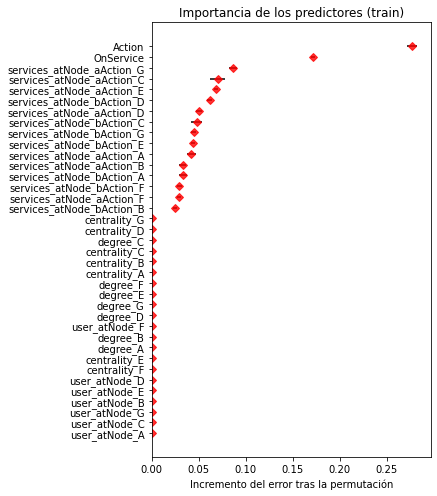

In [60]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

### Issues
- Related work with RF & Cloud/Fog/Edge computing 
- Improve the fitness function
- Hyperparametrization analysis
- More complex scenario -> version.B?

## RW:
- IMPROVING RESPONSE TIME OF TASK OFFLOADING BY RANDOM FOREST, EXTRA-TREES AND ADABOOST CLASSIFIERS IN MOBILE FOG COMPUTING https://www.ejmanager.com/mnstemps/71/71-1590557276.pdf?t=1636034459 Naive criteria: Authentication Confidentiality Integrity Availability Capacity Speed Cost
- ...